# Mask R-CNN for Keypoint Detection

Notebook for inspecting the Mask R-CNN data loader and model classes

In [1]:
USE_GPU = False

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Data for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare datasets
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = None

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=12.98s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


### List the Keypoint Classes

In [3]:
print("Classes:")
print(dataset_val.class_names)
print()
print("Keypoint classes:")
print(dataset_val.kp_class_names)

Classes:
['BG', 'person']

Keypoint classes:
['MISSING', 'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


### Show an Example Image
Shows how to use ```visualize.display_keypoints``` to show keypoints on an image

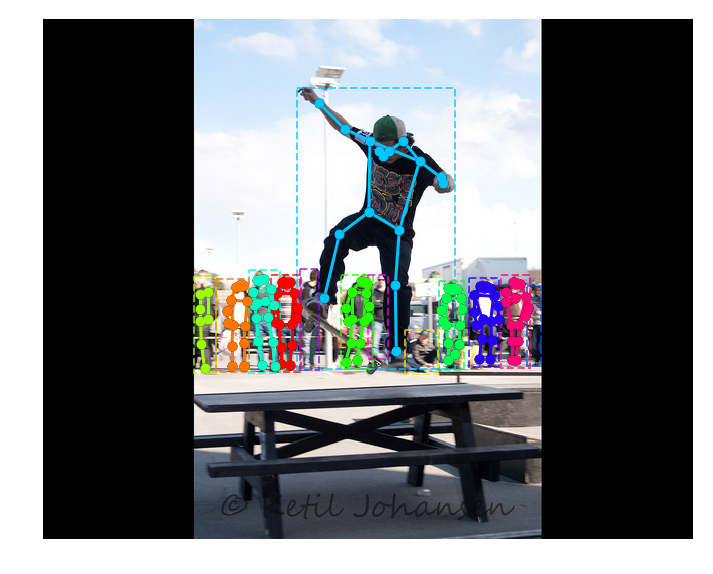

In [4]:
importlib.reload(visualize)

# Get an image from the validation set
image_id = dataset_train.image_ids[3]
image = dataset_train.load_image(image_id)

# Load masks and coresponding kp ids
masks, kp_ids = dataset_train.load_mask(image_id)
bbox = dataset_train.load_bbox(image_id)

# Show keypoints
visualize.display_keypoints(image, bbox, masks, kp_ids,
                            skeleton=dataset_val.skeleton,
                            figsize=(12, 12))

## Inspect Model

In [5]:
class TestConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
config = TestConfig()
#config.display()

### Model Dataloader

Show how the networks ```modellib.load_image_gt``` sees the mask, bounding box and kp ids

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 17)               min:    1.00000  max:   17.00000  int64
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 17)               min: 214526.00000  max: 822766.00000  int32


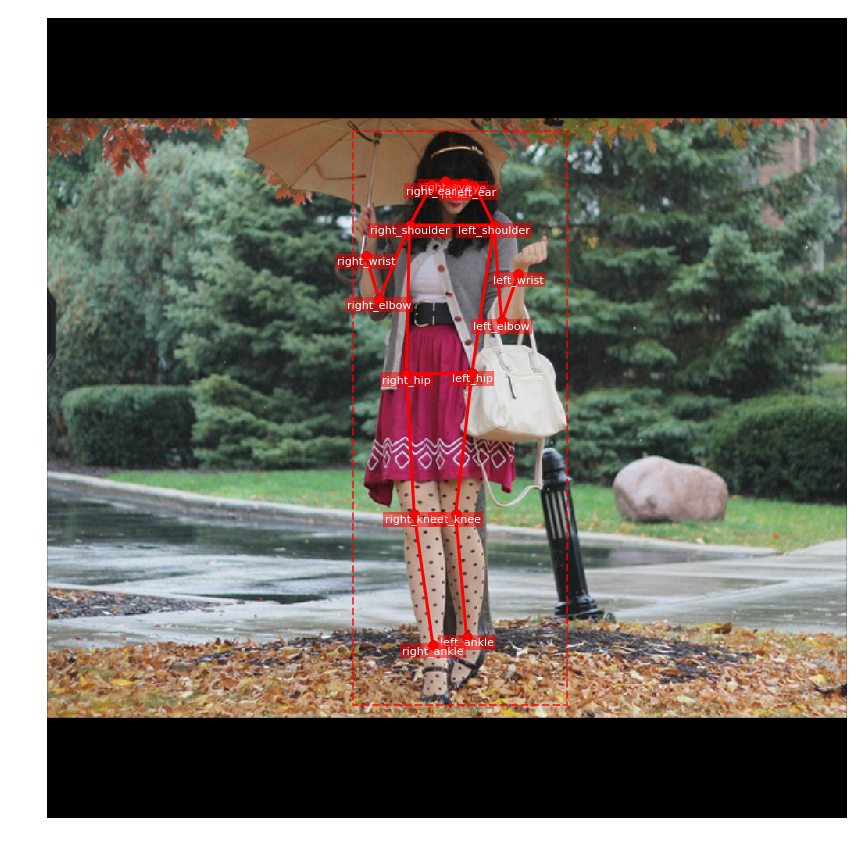

In [6]:
importlib.reload(modellib)
importlib.reload(visualize)

# Load an image from the validation set
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, config, image_id)
    
# Display some tensor sizes
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)

# Show skeletons
visualize.display_keypoints(image, gt_bbox, utils.sparse_to_dense_masks(gt_kp_masks, image.shape),
                            skeleton=dataset_train.skeleton,
                            captions=dataset_train.kp_class_names,
                            figsize=(15, 15))

## Inference Output

In [7]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

fpn_classifier_graph:
x.shape (?, 1000, 1, 1, 1024)

Level 0 (?, ?, ?, 256)
Level 1 (?, ?, ?, 256)
Level 2 (?, ?, ?, 256)
Level 3 (?, ?, ?, 256)
build_fpn_mask_graph:
x.shape (1, ?, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 28, 28, 256)
x.shape (?, 100, 28, 28, 17)
x.shape (?, 100, 17, 28, 28)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180605T0513/mask_rcnn_coco_keypoints_0020.h5


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 17, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 17, 28, 28)
masks.shape (5, 17, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (13, 17)              min:    0.00000  max:   17.00000  int64
bbox                     shape: (5, 4)                min:  152.00000  max:  901.00000  int32
masks                    shape: (5, 17, 1024, 1024)   min:    0.00000  m

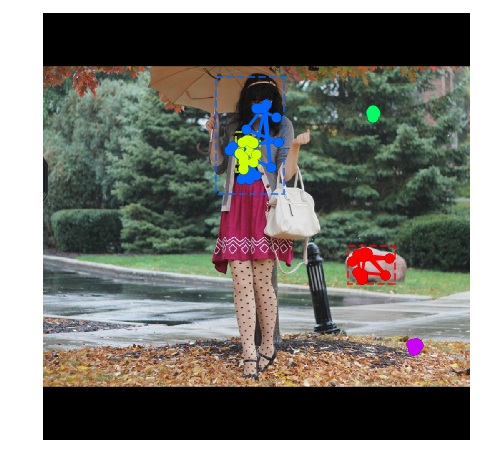

In [8]:
# Run the inference pipeline on the previous image
results = model.detect([image], verbose=1)
r = results[0]
bbox, masks = r["rois"], r["masks"]

# Show output tensors
log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", masks)

# Show skeletons
visualize.display_keypoints(image, bbox, masks,
                            skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

### Show Keypoint Heatmap

In [12]:
r['scores']

array([0.7361149 , 0.72846234, 0.7173121 , 0.7098898 , 0.7025439 ],
      dtype=float32)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (5, 4)                min:  152.00000  max:  901.00000  int32
masks                    shape: (5, 17, 1024, 1024)   min:    0.00000  max:    1.00000  float64


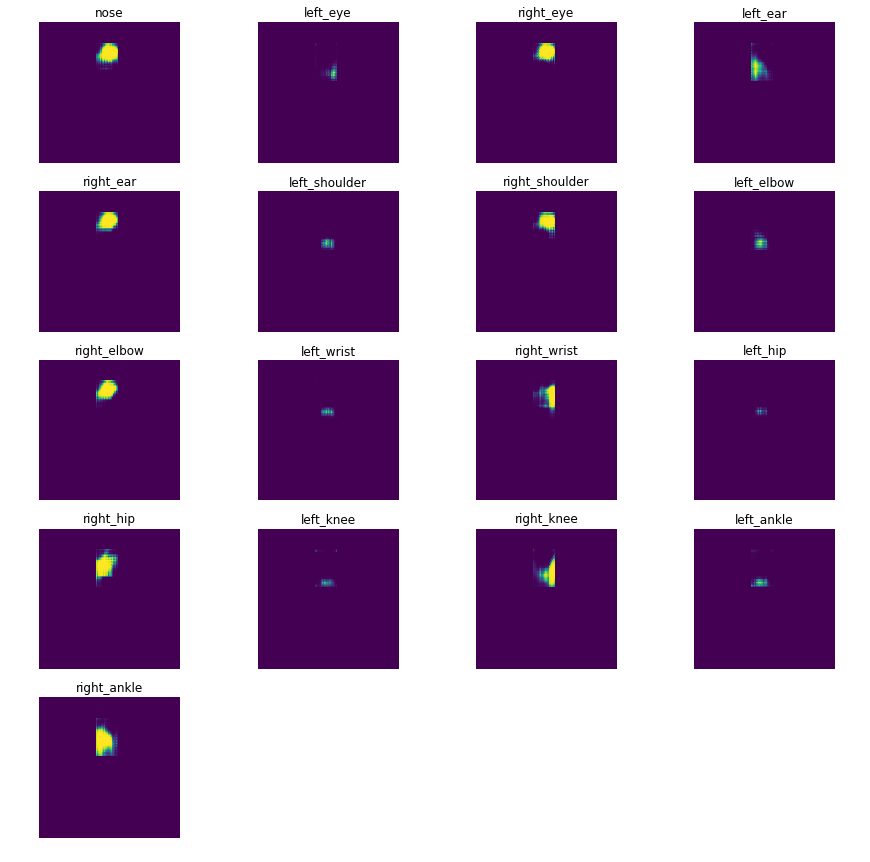

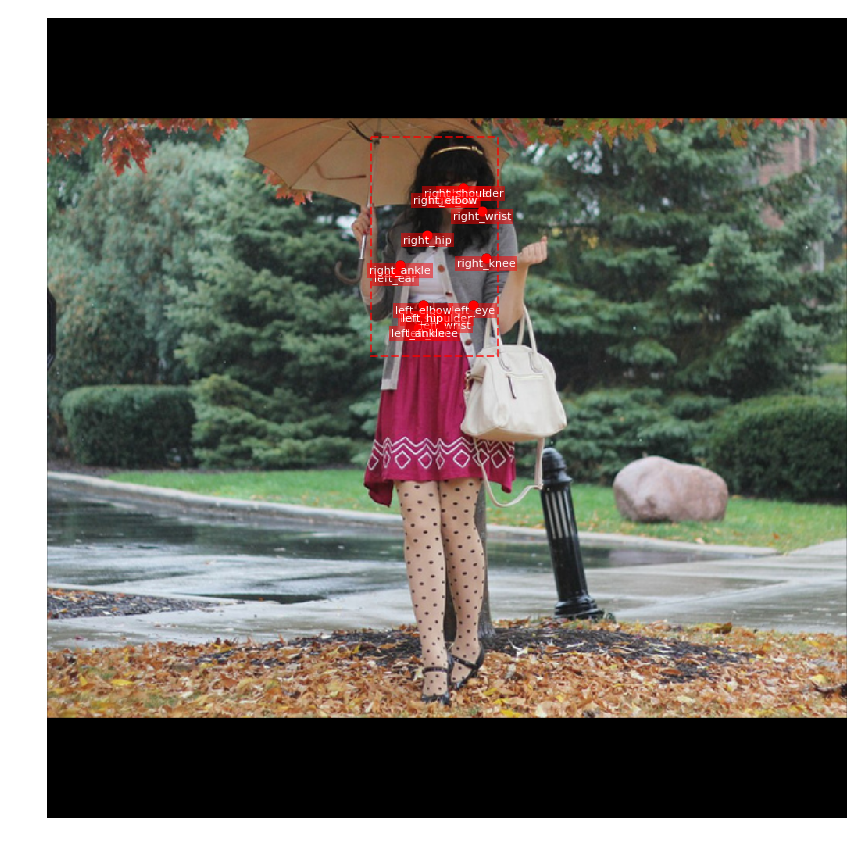

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

mask_index = 1

def plot_grid(images, titles=None):
    n = np.sqrt(len(images))
    _, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
    if n <= 1: axes = np.array(axes)
    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")
        if i >= config.NUM_KEYPOINTS: continue    
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(images[i])
    plt.show()

importlib.reload(visualize)
    
plot_grid(kp_masks[mask_index], titles=dataset_val.kp_class_names[1:])
visualize.display_keypoints(image, bbox[mask_index:mask_index+1], kp_masks[mask_index:mask_index+1],
                            #skeleton=dataset_train.skeleton
                            captions=dataset_train.kp_class_names,
                            figsize=(15, 15))

### Show Grid of Random Images

In [11]:
# Select 10 random images
images = []
for image_id in random.choice(dataset_val.image_ids, 10, replace=False):
    # Load an image from the validation set
    image_id = dataset_val.image_ids[10]
    image = modellib.load_image_gt(dataset_val, config, image_id)[0]
    images.append(image)

# Detect keypoints
results = model.detect(images)

# Plot results
for r in results:
    visualize.display_keypoints(image, r["rois"], r["masks"],
                                #skeleton=dataset_train.skeleton,
                                figsize=(8, 8))

TypeError: choice() got an unexpected keyword argument 'replace'